In [15]:
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X2.zip
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip

--2018-10-31 15:51:48--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X2.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.162
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X2.zip [following]
--2018-10-31 15:51:49--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X2.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 925390592 (883M) [application/zip]
Saving to: ‘DIV2K_train_LR_bicubic_X2.zip’

DIV2K_train_LR_bicu 100%[===================>] 882.52M  2.36MB/s    in 6m 6s   

2018-10-31 15:57:55 (2.41 MB/s) - ‘DIV2K_train_LR_bicubic_X2.zip’ saved [925390592/925390592]

--2018-10-31 15:57:57--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Resol

In [0]:
!unzip DIV2K_train_HR.zip 1>/dev/null
!unzip DIV2K_train_LR_bicubic_X2.zip >/dev/null

In [19]:
ls

DIV2K_train_HR/     DIV2K_train_LR_bicubic/        sample_data/
DIV2K_train_HR.zip  DIV2K_train_LR_bicubic_X2.zip


(256, 256, 3)
(2048, 2048, 3)


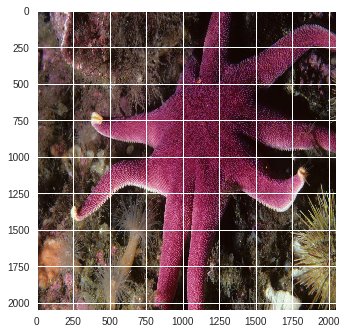

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
f = Image.open("DIV2K_train_LR_bicubic/X2/0001x2.png")
f = f.resize((256,256))
print(np.asarray(f).shape)

f = Image.open("DIV2K_train_HR/0001.png")
f = f.resize((2048,2048))
print(np.asarray(f).shape)
plt.imshow(np.asarray(f))

In [0]:
import tensorflow as tf
from functools import reduce
def weights(shape):
    return tf.Variable(tf.random_normal(shape))
def biases(shape):
    return tf.Variable(tf.random_normal([shape]))
def flatten(input_):
  #s = reduce(lambda x,y:x*y,list(map(input_.shape[1:],int)))
  return tf.reshape(input_,[-1,input_.shape[1:].num_elements()])
def dense(input_,out):
  w = weights(int(input_.shape[-1]),out)
  b = biases(out)
  return tf.matmul(input_,w)+b
def conv2d(input_,filter_size,outchannel,activate = False, normalize = False,strides = [1,1,1,1]):
    inchannel = int(input_.shape[-1])
    filter_ = weights([filter_size,filter_size,inchannel,outchannel])
    conv = tf.nn.conv2d(input_,filter_,padding = "SAME",strides = strides)
    bias = biases(outchannel)
    out = conv+bias
    if normalize:
        out = tf.layers.batch_normalization(out)
    if activate:
        out = tf.contrib.keras.layers.PReLU(shared_axes = [1,2])(out)
    return out
def generator_model(input_,high_res_):
    vgg19 = tf.keras.applications.VGG19(include_top = False, weights = "imagenet")
    for layer in vgg19.layers:
      layer.trainable = False
    x = conv2d(input_,9,64,activate = True)
    h = x
    with tf.name_scope("Residual_Blocks"):
      for i in range(5):
          h1 = conv2d(h,3,64,activate = True,normalize = True)
          h2 = conv2d(h1,3,64,normalize = True)
          h = h + h2
    with tf.name_scope("final_element_wise_add"):
      h = conv2d(input_,3,64,normalize = True)
      h = h + x
    with tf.name_scope("pixel_shuffle_layers"):
      for i in range(2):
        h = conv2d(h,3,256)
        h = tf.depth_to_space(h,2)
        h = tf.contrib.keras.layers.PReLU(shared_axes = [1,2])(h)
    with tf.name_scope("final_conv"):
      out = conv2d(h,9,3)
    v1 = vgg19(out)
    v2 = vgg19(high_res_)
    loss = tf.reduce_mean(tf.square(v2-v1))
    return out,loss
def discriminator_model(input_):
#    ones = tf.ones([tf.shape(hr_)[0]])
#    zeros = tf.zeros([tf.shape(sr_)[0]])
#    labels_ = tf.stack([zeros,ones])
    h = tf.nn.leaky_relu(conv2d(input_,3,64))
    for i in range(4):
        if i:
          h = tf.nn.leaky_relu(conv2d(h,3,(2**i)*64,normalize = True))
        h = tf.nn.leaky_relu(conv2d(h,3,(2**i)*64,normalize = True,strides = [1,2,2,1]))
        
    h = flatten(h)
    h = tf.nn.leaky_relu(dense(h,1024))
    out = tf.nn.sigmoid(dense(h,1))
#    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = labels_, logits = out))
#    return loss
    return out
    
    

In [9]:
LR = tf.placeholder(tf.float32,[None,256,256,3])
HR = tf.placeholder(tf.float32,[None,2048,2048,3])
genOut,l_content = generator_model(LR,HR)
with tf.variable_scope("Disc"):
  fakeOut = discriminator_model(genOut)
  fake = tf.zeros_like(discOut)
  l1 = tf.nn.sigmoid_cross_entropy_with_logits(labels = fake,logits = fakeOut)
with tf.variable_scope("Disc") as scope:
  scope.reuse_variables()
  realOut = discriminator_model(HR)
  real = tf.ones_like(realOut)
  l2 = tf.nn.sigmoid_cross_entropy_with_logits(labels = real,logits = realOut)
l_gen = l1 + l2 #Train Discriminator
adv_loss = l_content + tf.constant(1e-3,tf.float32)*l_gen #Train Generator

ValueError: ignored

In [0]:
import os
try:
  os.mkdir("logs")
except:
  pass
with tf.Session() as sess:
  #sess.run(tf.global_variables_initializer())
  writer = tf.summary.FileWriter("logs",sess.graph)
  #sess.run(o)
  writer.close()

In [38]:
!zip -r logs.zip logs

updating: logs/ (stored 0%)
updating: logs/events.out.tfevents.1541004901.e92174c9a649 (deflated 92%)
updating: logs/events.out.tfevents.1541005069.e92174c9a649 (deflated 92%)
updating: logs/events.out.tfevents.1541004955.e92174c9a649 (deflated 92%)
  adding: logs/events.out.tfevents.1541009688.e92174c9a649 (deflated 92%)
